In [ ]:
#gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
!pip install requests

In [ ]:
!pip install seaborn

In [ ]:
#imports
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load

File id = File identifies it
Access token = to authenticate with figma api

In [ ]:
def get_figma_data(file_id, access_token):
  """
  A method to import figma data

  Parameters
  file_id = File id to identify the figma component file
  access_token = to authenticate with figma api
  """
  #url for figma file
  url= f"https://api.figma.com/v1/files/{file_id}"
  #setting up headers for http requests
  headers={"X-Figma-token":access_token}
  #http GET request to figma api to get file data
  response = requests.get(url,headers=headers)
  return response.json()

In [ ]:
#figma file id
file_id= "<INSERT FILE ID>"

In [ ]:
#figma access token
access_token= "<INSERT ACCESS TOKEN>"

In [ ]:
figma_data= get_figma_data(file_id, access_token)

In [ ]:
#print(file_data)

## Check save data

In [ ]:
# print(json.dumps(figma_data, indent=2))

In [ ]:
def variant_count(figma_data):
  """
  A method to see number of component variants count

  Parameters
  file_data = data extracted from figma
  """
  #initialise the count
  variant_count = 0
  #function to count variants
  def count_variants(node_data):
    nonlocal variant_count
    #check if layer = component set
    if node_data.get("type") == "COMPONENT_SET":
      #count the number of children
      variant_count += len(node_data.get("children", []))
    for child in node_data.get("children", []):
      count_variants(child)
  count_variants(figma_data.get("document"))
  return variant_count

In [ ]:
# #testing
# variants_count = variant_count(figma_data)
# print(f"Total component variants: {variants_count}")

In [ ]:
def save_figma_data(figma_data, saved_path):
  """
  A method to save figma data in a file

  Parameters
  figma_data = data extracted from figma
  saved_path = path to save the data
  """
  with open(saved_path, 'w') as f:
    f.write(json.dumps(figma_data, indent=4))

In [ ]:
#path to save data
data_path = '/content/drive/My Drive/Implementation/Final Thesis/FYP/extracted_figma_data.json'

In [ ]:
save_figma_data(figma_data, data_path)

In [ ]:
def extract_componentset_name(node_name):
  """
  A method to extract the component set name

  Parameters
  node_name = name of the component set node
  """
  naming_parts = node_name.split('/')
  #no of parts in the naming is 3
  if len(naming_parts) == 3:
    #naming types
    style, component_name, subtype = naming_parts
  else:
    #default names if not found
    style, component_name, subtype = 'Unknown', 'Unknown', 'Unknown'
  return style.strip(), component_name.strip(), subtype.strip()

In [ ]:
def extract_variant_name(variant_name):
  """
  A method to extract the variant name key value pairs

  Parameters
  variant_name = name of the variant node
  """
  variant_details = {}
  #split the variant name
  key_value_pairs = variant_name.split(',')
  for pair in key_value_pairs:

    #define teh key value pairs and split
    key, value = pair.split('=') if '=' in pair else ('Unknown', 'Unknown')

    #get the key
    key = key.strip()

    #get the value
    value = value.strip()
    if key not in variant_details:
      variant_details[key] = [value]
    else:
      variant_details[key].append(value)
  return variant_details if variant_details else {'state': ['default']}

## Simple json extraction

In [ ]:
def extract_simple_properties(node):
  """
  A method to extract the simple properties of the component variants

  Parameters
  node = node to extract the properties from
  """
  properties = {
    'color': [],
    'strokes': [],
    'strokeWeight': 0,
    'text': [],
    'textColor': [],
    'borderRadius': [],
    'fontFamily': [],
    'fontWeight': [],
    'fontSize': [],
    'effects': [],
    'padding': 0,
    'width': 0,
    'height': 0,
    'x': 0,
    'y': 0,
    'hasIcon': False
  }
  simple_property_extraction(node, properties)
  return properties

In [ ]:
def simple_property_extraction(node, properties):
  """
  A method to extract the properties of the component variants

  Parameters
  node = node to extract the properties from
  properties = dictionary to store the properties
  """
  #colors
  fills = node.get('fills', [])
  for fill in fills:
    if fill['type'] == 'SOLID':
      color = fill['color']
      rgba = f"rgba({int(color['r'] * 255)}, {int(color['g'] * 255)}, {int(color['b'] * 255)}, {color['a']})"
      properties['color'] = rgba

  #corner radius
  if 'cornerRadius' in node:
    properties['borderRadius'] = node['cornerRadius']

  #text properties
  if node['type'] == 'TEXT':
    properties['text'] = node.get('characters', '')
    textStyle = node.get('style', {})
    properties['fontFamily'] = textStyle.get('fontFamily', '')
    properties['fontWeight'] = textStyle.get('fontWeight', '')
    properties['fontSize'] = textStyle.get('fontSize', 0)
    textFills = node.get('fills', [])
    for fill in textFills:
      if fill['type'] == 'SOLID':
        color = fill['color']
        rgba = f"rgba({int(color['r'] * 255)}, {int(color['g'] * 255)}, {int(color['b'] * 255)}, {color['a']})"
        properties['textColor'] = rgba

  #dimensions
  if 'absoluteBoundingBox' in node:
    boundingBox = node['absoluteBoundingBox']
    properties['width'] = boundingBox['width']
    properties['height'] = boundingBox['height']
    properties['x'] = boundingBox['x']
    properties['y'] = boundingBox['y']

  #strokes
  strokes = node.get('strokes', [])
  for stroke in strokes:
    if stroke['type'] == 'SOLID':
      color = stroke['color']
      rgba = f"rgba({int(color['r'] * 255)}, {int(color['g'] * 255)}, {int(color['b'] * 255)}, {color['a']})"
      properties['strokes'].append(rgba)
  strokeWeight = node.get('strokeWeight', 0)
  properties['strokeWeight'] = strokeWeight

  #effects
  effects = node.get('effects', [])
  for effect in effects:
    color = effect.get('color', {})
    rgba = f"rgba({int(color.get('r', 0) * 255)}, {int(color.get('g', 0) * 255)}, {int(color.get('b', 0) * 255)}, {color.get('a', 1)})"
    properties['effects'].append({'type': effect['type'], 'color': rgba})

  #padding
  if 'padding' in node:
    properties['padding'] = node['padding']

  #icon presence
  if node['type'] == 'VECTOR':
    properties['hasIcon'] = True

  #go through child nodes
  if 'children' in node:
    for child in node['children']:
      simple_property_extraction(child, properties)

In [ ]:
def process_simple_variants(node, style, component_name, subtype):
  """
  A method to process the simple variants

  Parameters
  node = node to process the variants from
  style = style of the component
  component_name = name of the component
  subtype = subtype of the component

  Return
  variants = list of variants
  """
  variants = []
  #check if layer = component set
  if node['type'] == 'COMPONENT_SET' or node['type'] == 'COMPONENT':
    variant_nodes = node['children'] if node['type'] == 'COMPONENT_SET' else [node]
    for child in variant_nodes:
      #extract variant details
      variant_details = extract_variant_name(child['name'])
      #extract simple properties
      variant_properties = extract_simple_properties(child)
      #append to variants
      variant_properties.update({
        "style": style,
        "component_name": component_name,
        "subtype": subtype,
        "variant_details": variant_details,
      })
      #append to variants
      variants.append({"variant_properties": variant_properties})
  return variants

In [ ]:
def output_simple_data(file_data, component_types):
  """
  A method to output the simple data

  Parameters
  file_data = data extracted from figma
  component_types = list of component types to extract
  """
  organized_data = []
  #canvas
  for canvas in file_data.get("document", {}).get("children", []):
    #get children
    for node in canvas.get("children", []):
      #select component set data
      if node["type"] in ["COMPONENT_SET", "COMPONENT"]:
        #extract component name
        style, component_name, subtype = extract_componentset_name(node["name"])
        if component_name.lower() in component_types:
          #process variants
          variants = process_simple_variants(node, style, component_name, subtype)
          organized_data.extend(variants)
  return organized_data

In [ ]:
def print_output(data, component_types):
  """
  A method to print the output

  Parameters
  data = data to print
  component_types = list of component types to print
  """
  for comp_type in component_types:
    samples = [d for d in data if d["variant_properties"]["component_name"].lower() == comp_type][:2]
    for sample in samples:
      print(json.dumps(sample, indent=4))


In [ ]:
def simple_data_output(figma_data):
  """
  A method to output the simple data

  Parameters
  figma_data = data extracted from figma
  """
  component_types = ['button', 'input-field']
  organized_data = output_simple_data(figma_data, component_types)
  print_output(organized_data, component_types)

In [ ]:
simple_data_output(figma_data)

{
    "variant_properties": {
        "color": "rgba(255, 255, 255, 1.0)",
        "strokes": [
            "rgba(126, 86, 216, 1.0)"
        ],
        "strokeWeight": 1.0,
        "text": "Button CTA",
        "textColor": "rgba(255, 255, 255, 1.0)",
        "borderRadius": 10.0,
        "fontFamily": "Inter",
        "fontWeight": 500,
        "fontSize": 14.0,
        "effects": [
            {
                "type": "DROP_SHADOW",
                "color": "rgba(16, 24, 40, 0.05000000074505806)"
            }
        ],
        "padding": 0,
        "width": 77.0,
        "height": 20.0,
        "x": -4619.0,
        "y": -2135.0,
        "hasIcon": false,
        "style": "Professional",
        "component_name": "Button",
        "subtype": "Default",
        "variant_details": {
            "State": [
                "Default"
            ],
            "Size": [
                "Small"
            ]
        }
    }
}
{
    "variant_properties": {
        "color": "rgba(255, 25

In [ ]:
#path
simplified_data_path = '/content/drive/My Drive/Implementation/Final Thesis/FYP/simplecomponents.jsonl'

In [ ]:
#define components
organized_data = output_simple_data(figma_data, ['button', 'input-field', 'menu', 'list-item', 'label', 'icon-button'])

In [ ]:
save_data(organized_data, simplified_data_path)

### Showing part

In [ ]:
def prepare_data_for_normalization(processed_data):
  """
  A method to prepare the data for normalization

  Parameters
  processed_data = data to prepare for normalization
  """
  prepared_data = []
  for entry in processed_data:
    #variant properties
    variant_properties = entry.get('variant_properties', {})
    if isinstance(variant_properties, dict):
      #list
      variant_properties = [variant_properties]
    for variant in variant_properties:
      prepared_data.append(variant)
  return prepared_data

In [ ]:
def load_normalize_data(processed_data):
  """
  A method to load and normalize the data

  Parameters
  processed_data = data to load and normalize
  """
  prepared_data = prepare_data_for_normalization(processed_data)
  #load
  df = pd.json_normalize(prepared_data)
  return df

In [ ]:
#loading and normalising
df = load_normalize_data(processed_data)

In [ ]:
def display_basic_statistics(df):
  """
  A method to display basic statistics of the data

  Parameters
  df = data to display basic statistics
  """
  #stats for numeric data
  numeric_df = df.select_dtypes(include=['number'])
  print("Numeric columns stats:")
  print(numeric_df.describe())

  #stats for categorical data
  categorical_df = df.select_dtypes(exclude=['number'])
  for column in categorical_df.columns:
    print(f"\nStats for categorical column: {column}")
    print(categorical_df[column].value_counts())

In [ ]:
#display
display_basic_statistics(df)

Numeric columns stats:
             width       height  layout.padding.left  layout.padding.right  \
count  5648.000000  5648.000000          5360.000000           5360.000000   
mean    136.836450    42.989800             7.410485              7.378022   
std     111.400199    19.513321             8.365775              8.403555   
min      16.000002    16.000000             0.000000              0.000000   
25%      57.000000    32.000000             0.000000              0.000000   
50%      87.000000    40.000000             4.000000              4.000000   
75%     210.000000    48.000000            15.000000             15.000000   
max     451.000000   180.000000            40.000000             40.000000   

       layout.padding.top  layout.padding.bottom  layout.itemSpacing  
count         5360.000000            5360.000000         5360.000000  
mean             3.077649               3.078396            4.148134  
std              4.869524               4.872577            4

In [ ]:
def display_component_type_distribution(df):
  """
  A method to plot the component type distribution

  Parameters
  df = data to plot the component type distribution
  """
  print("Component type distribution:")
  component_count = df['component_name'].value_counts()
  component_count.plot(kind='bar', title='Component type distribution')
  plt.xlabel('Component type')
  plt.ylabel('Count of components')
  plt.show()

Component type distribution:


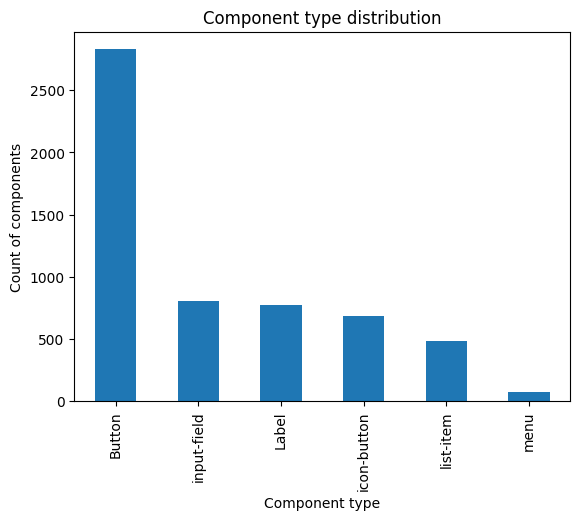

In [ ]:
#plot
display_component_type_distribution(df)

In [ ]:
def analyze_auto_layout_usage(df):
  """
  A method to analyze the auto-layout usage

  Parameters
  df = data to analyze the auto-layout usage
  """
  auto_layout_count = df['layout.mode'].value_counts()
  auto_layout_count.plot(kind='bar', title='Auto layout mode distribution')
  plt.xlabel('Auto layout mode')
  plt.ylabel('Count')
  plt.show()

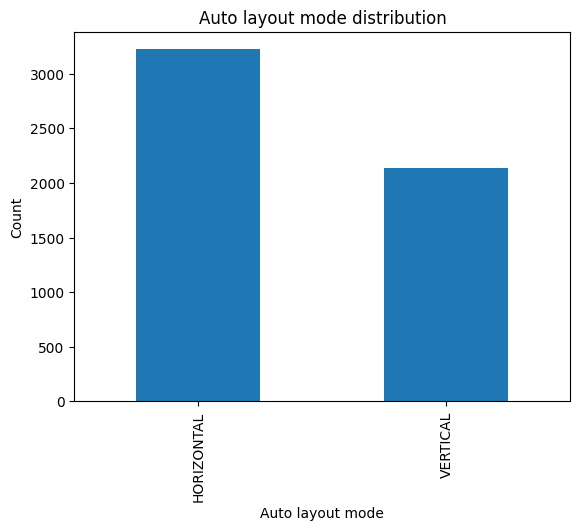

In [ ]:
analyze_auto_layout_usage(df)

In [ ]:
def analyze_padding_in_auto_layouts(df):
  """
  A method to analyze the padding in auto-layouts

  Parameters
  df = data to analyze the padding in auto-layouts
  """
  print("Padding in auto layouts:")
  df[['layout.padding.left', 'layout.padding.right', 'layout.padding.top', 'layout.padding.bottom']].hist(bins=30, figsize=(10, 5))
  plt.suptitle('Padding distribution in auto layouts')
  plt.show()


Padding in auto layouts:


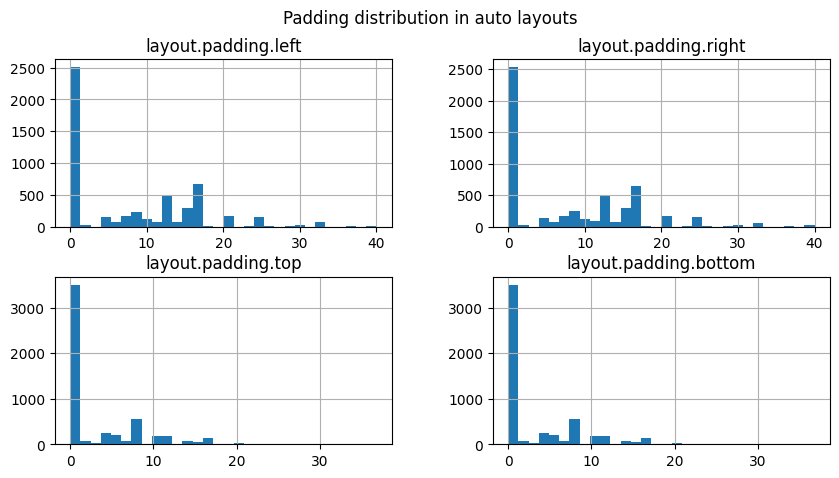

In [ ]:
analyze_padding_in_auto_layouts(df)

In [ ]:
def plot_component_types_by_style(df):
  """
  A method to plot the component types by style

  Parameters
  df = data to plot the component types by style
  """
  component_style_count = df.groupby(['style', 'component_name']).size().unstack().fillna(0)
  component_style_count.plot(kind='bar', stacked=True, figsize=(15, 7))
  plt.title('Distribution of component types by style')
  plt.xlabel('Style')
  plt.ylabel('Count')
  plt.legend(title='Component Type')
  plt.show()

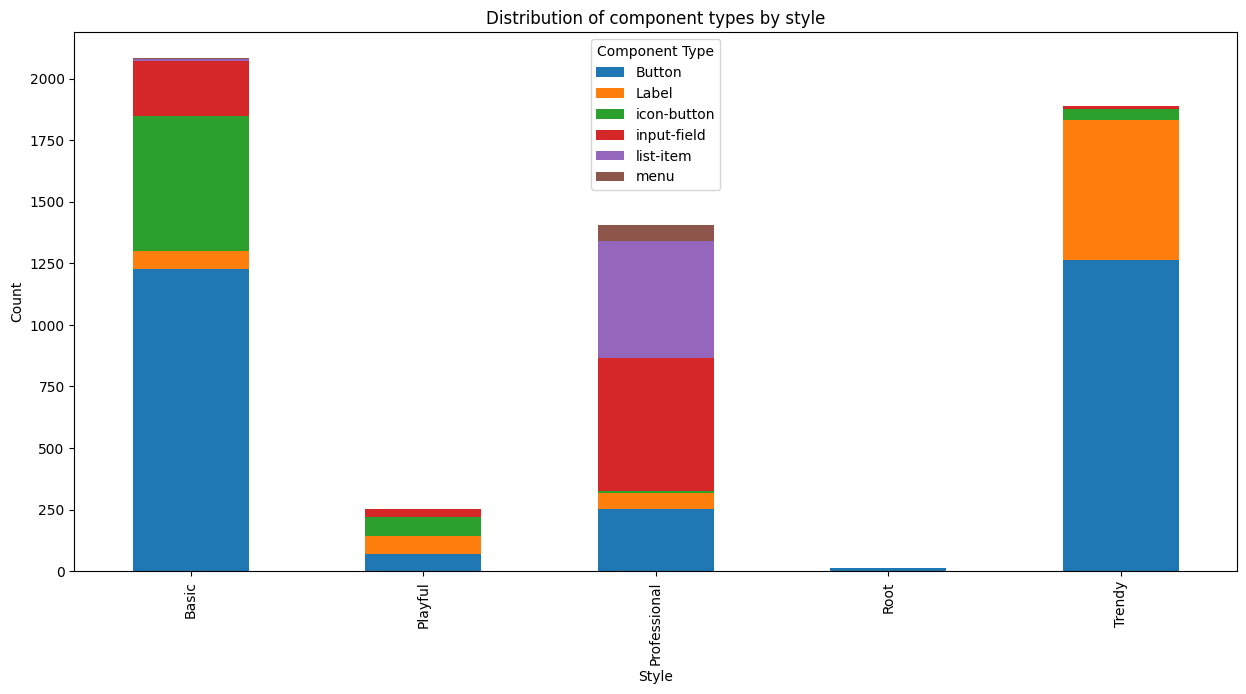

In [ ]:
plot_component_types_by_style(df)

In [ ]:
def plot_padding_distribution(df):
  """
  A method to plot the padding distribution

  Parameters
  df = data to plot the padding distribution
  """
  df[['layout.padding.left', 'layout.padding.right', 'layout.padding.top', 'layout.padding.bottom']].hist(bins=30, figsize=(10, 10))
  plt.suptitle('Distribution of padding in components')
  plt.show()

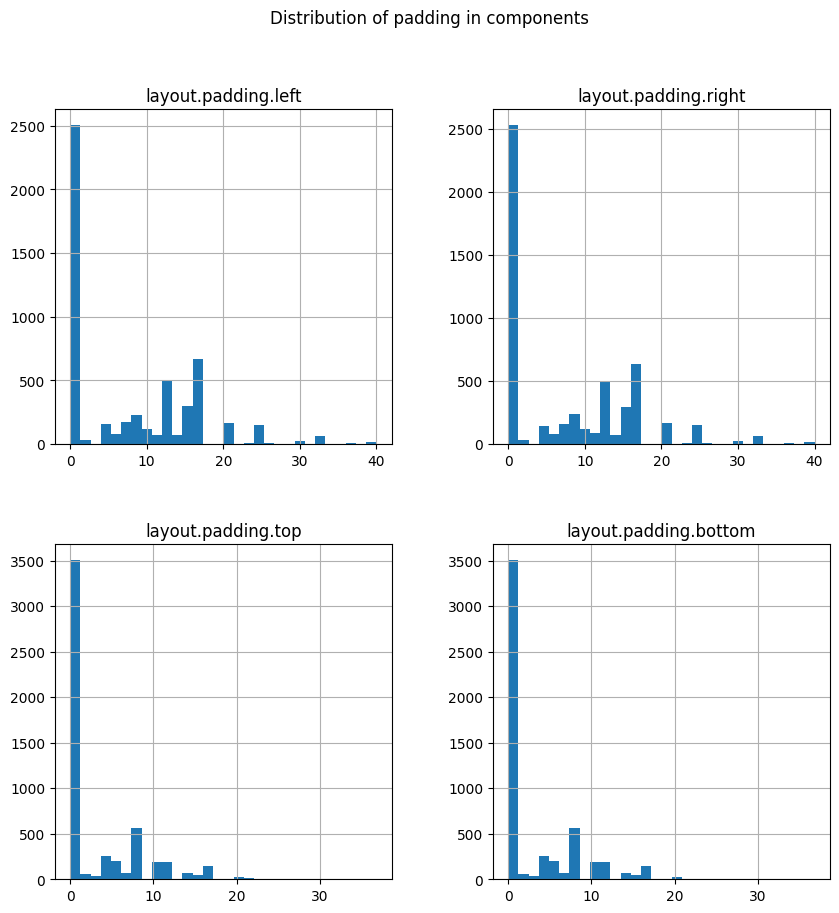

In [ ]:
plot_padding_distribution(df)

In [ ]:
def plot_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=['number']).dropna()
    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix for numeric features')
    plt.show()

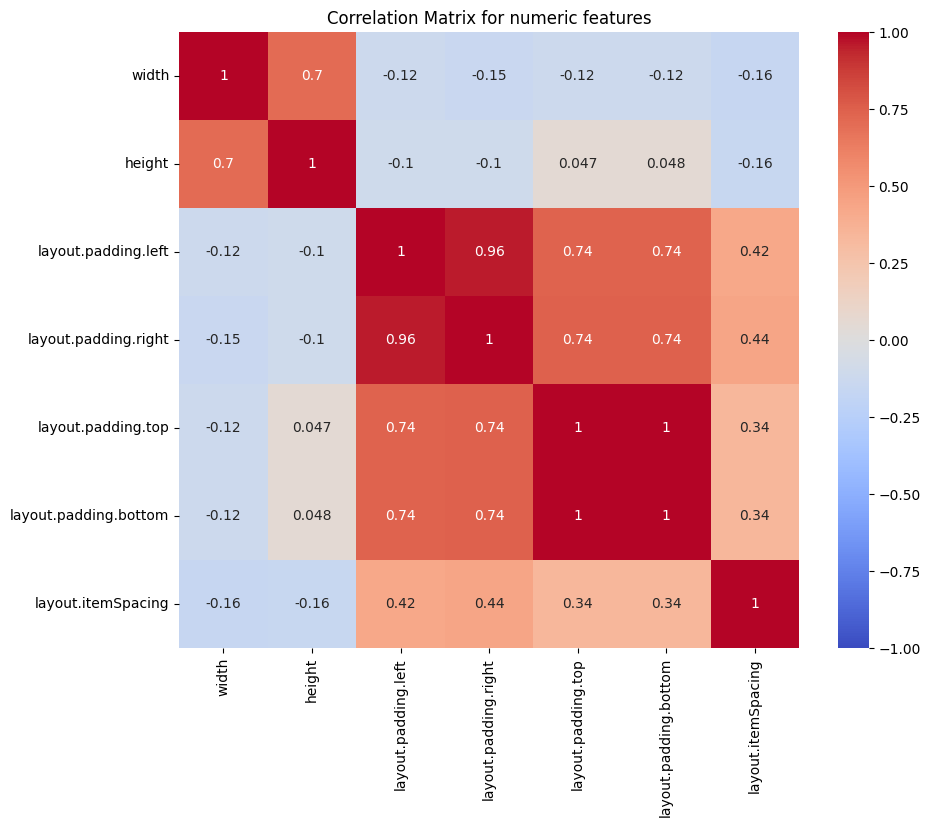

In [ ]:
plot_correlation_matrix(df)

In [ ]:
def unique_component_count_by_type(df):
  """
  A method to print the unique component types

  Parameters
  df = data to print the unique component types
  """
  unique_counts = df['component_name'].nunique()
  print(f'Unique Component Types: {unique_counts}')

In [ ]:
unique_component_count_by_type(df)

Unique Component Types: 6


In [ ]:
def most_common_colors(df, top_n=10):
  """
  A method to print the most common colors

  Parameters
  df = data to print the most common colors
  top_n = number of colors to print
  """
  colors = df['fills'].explode().dropna().apply(lambda x: x.get('color') if isinstance(x, dict) else None).dropna()
  color_counts = colors.value_counts().head(top_n)
  print(f'Top {top_n} Most Common Colors:')
  print(color_counts)


In [ ]:
most_common_colors(df)

Top 10 Most Common Colors:
fills
{'r': 1.0, 'g': 1.0, 'b': 1.0, 'a': 1.0}                                                    1086
{'r': 0.0, 'g': 0.0, 'b': 0.0, 'a': 1.0}                                                     496
{'r': 0.9960784316062927, 'g': 0.9686274528503418, 'b': 1.0, 'a': 1.0}                       300
{'r': 0.0784313753247261, 'g': 0.07058823853731155, 'b': 0.0941176488995552, 'a': 1.0}       299
{'r': 0.30588236451148987, 'g': 0.27450981736183167, 'b': 0.7058823704719543, 'a': 1.0}      120
{'r': 0.4627451002597809, 'g': 0.4627451002597809, 'b': 0.501960813999176, 'a': 1.0}         117
{'r': 0.9098039269447327, 'g': 0.8705882430076599, 'b': 0.9725490212440491, 'a': 1.0}         92
{'r': 0.29019609093666077, 'g': 0.2666666805744171, 'b': 0.3450980484485626, 'a': 1.0}        92
{'r': 0.9686274528503418, 'g': 0.9490196108818054, 'b': 0.9803921580314636, 'a': 1.0}         58
{'r': 0.03529411926865578, 'g': 0.11764705926179886, 'b': 0.25882354378700256, 'a': 1.0}      

In [ ]:
def average_padding_by_component(df):
  """
  A method to print the average padding by component type

  Parameters
  df = data to print the average padding by component type
  """
  padding_df = df[['component_name', 'layout.padding.left', 'layout.padding.right', 'layout.padding.top', 'layout.padding.bottom']]
  average_padding = padding_df.groupby('component_name').mean()
  print('Average Padding by component type:')
  print(average_padding)


In [ ]:
average_padding_by_component(df)

Average Padding by component type:
                layout.padding.left  layout.padding.right  layout.padding.top  \
component_name                                                                  
Button                    11.324314             11.386052            4.774009   
Label                      4.792699              4.959583            1.543677   
icon-button                3.198174              3.204262            2.315373   
input-field                4.544974              3.931217            0.989418   
list-item                  0.000000              0.000000            0.000000   
menu                      11.000000             10.944444            7.166667   

                layout.padding.bottom  
component_name                         
Button                       4.774009  
Label                        1.543677  
icon-button                  2.321461  
input-field                  0.989418  
list-item                    0.000000  
menu                         7.16666

In [ ]:
def most_common_effects(df, top_n=5):
  """
  A method to print the most common effects

  Parameters
  df = data to print the most common effects
  top_n = number of effects to print
  """
  effects = df['effects'].explode().dropna().apply(lambda x: x.get('type') if isinstance(x, dict) else None).dropna()
  effect_counts = effects.value_counts().head(top_n)
  print(f'Top {top_n} Most Common Effects:')
  print(effect_counts)

In [ ]:
most_common_effects(df)

Top 5 Most Common Effects:
effects
DROP_SHADOW        1914
BACKGROUND_BLUR     131
INNER_SHADOW         44
Name: count, dtype: int64


## Nested extraction

In [ ]:
def extract_properties(node):
  """
  A method to extract the properties of the component variants

  Parameters
  node = node to extract the properties from
  """

  #incommon properties
  properties = {
    'name': node.get('name', ''),
    'type': node.get('type', '')
  }

  #text
  if node['type'] == 'TEXT':
    text_style = node.get('style', {})
    properties.update({
      'fontFamily': text_style.get('fontFamily', ''),
      'fontWeight': text_style.get('fontWeight', ''),
      'fontSize': text_style.get('fontSize', ''),
      'characters': node.get('characters', ''),
      'textColor': next((fill.get('color', {}) for fill in node.get('fills', []) if fill.get('type') == 'SOLID'), {})
    })

  #for icons
  elif node['type'] == 'VECTOR':
    properties.update({
      'iconWidth': node.get('absoluteBoundingBox', {}).get('width', 0),
      'iconHeight': node.get('absoluteBoundingBox', {}).get('height', 0),
      'iconColor': next((fill.get('color', {}) for fill in node.get('fills', []) if fill.get('type') == 'SOLID'), {})
    })

  #line
  elif node['type'] == 'LINE':
    properties.update({
      'lineThickness': node.get('strokeWeight', 0),
      'lineColor': next((stroke.get('color', {}) for stroke in node.get('strokes', []) if stroke.get('type') == 'SOLID'), {})
    })

  #rectangle
  elif node['type'] == 'RECTANGLE':
    properties.update({
      'width': node.get('absoluteBoundingBox', {}).get('width', 0),
      'height': node.get('absoluteBoundingBox', {}).get('height', 0),
      'fillColor': next((fill.get('color', {}) for fill in node.get('fills', []) if fill.get('type') == 'SOLID'), {})
    })

  #frames, groups
  elif node['type'] in ['FRAME', 'GROUP']:
    properties.update({
      'width': node.get('absoluteBoundingBox', {}).get('width', 0),
      'height': node.get('absoluteBoundingBox', {}).get('height', 0),
      'fills': [{'color': fill.get('color', {})} for fill in node.get('fills', []) if fill.get('type') == 'SOLID'],
      'strokes': [{'color': stroke.get('color', {}), 'weight': node.get('strokeWeight', 0)} for stroke in node.get('strokes', []) if stroke.get('type') == 'SOLID'],
      'effects': node.get('effects', []),
      'borderRadius': node.get('cornerRadius', 0),
      'strokeWeight': node.get('strokeWeight', 0),
    })

  #populate the children
  if 'children' in node:
    properties['children'] = [extract_properties(child) for child in node['children']]

  return properties


In [ ]:
def process_variants(node, style, component_name, subtype):
  """
  A method to process the variants and get properties

  Parameters
  node = node to process the variants from
  style = style of the component
  component_name = name of the component
  subtype = subtype of the component
  Return
  variants = list of variants
  """
  variants = []
  #check if component
  if node['type'] == 'COMPONENT_SET' or node['type'] == 'COMPONENT':
    #get children
    variant_nodes = node['children'] if node['type'] == 'COMPONENT_SET' else [node]
    for child in variant_nodes:
      #extract variant details
      variant_details = extract_variant_name(child['name'])
      #extract properties
      variant_properties = extract_properties(child)
      #order of extraction
      output_variant_properties = {
        "style": style,
        "component_name": component_name,
        "subtype": subtype,
        "variant_details": variant_details,
        **variant_properties
      }
      #append to variants
        variants.append({"variant_properties": output_variant_properties})
  return variants

In [ ]:
def output_data(file_data, component_types):
  """
  A method to output the data

  Parameters
  file_data = data extracted from figma
  component_types = list of component types to extract
  Return
  organized_data = list of variants
  """
  organized_data = []
  #canvas
  for canvas in file_data.get("document", {}).get("children", []):
    for node in canvas.get("children", []):
      #select component set data
      if node["type"] in ["COMPONENT_SET", "COMPONENT"]:
        #extract component data
        style, component_name, subtype = extract_componentset_name(node["name"])
        if component_name.lower() in component_types:
          #process variants
          variants = process_variants(node, style, component_name, subtype)
          organized_data.extend(variants)
  return organized_data

In [ ]:
def print_output(file_data, component_types):
  """
  A method to print the output

  Parameters
  file_data = data extracted from figma
  component_types = list of component types to extract
  """
  for comp_type in component_types:
    #get samples
    samples = [d for d in file_data if d["variant_properties"]["component_name"].lower() == comp_type][:2]
    for sample in samples:
      print(json.dumps(sample, indent=4))


In [ ]:
def process_data(file_data):
  """
  A method to process the data for all componenets

  Parameters
  file_data = data extracted from figma
  """
  #list of components
  component_types = ['button', 'input-field', 'menu', 'list-item', 'label', 'icon-button'  ]
  component_types = [ctype.replace(" ", "").lower() for ctype in component_types]
  return output_data(file_data, component_types)

In [ ]:
def save_data(data, file_path):
  """
  A method to save the data

  Parameters
  data = data to save
  file_path = path to save the data
  """
  with open(file_path, 'w') as f:
    for entry in data:
      compact_json = json.dumps(entry, separators=(',', ':'))
      f.write(compact_json + '\n')


In [ ]:
#path
data_path = '/content/drive/My Drive/Implementation/Final Thesis/FYP/Data/nested_dataset.jsonl'

In [ ]:
processed_data = process_data(figma_data)

In [ ]:
save_data(processed_data, data_path)

## Complex extraction

In [ ]:
def extract_properties(node):
  """
  A method to extract the properties of the component variants

  Parameters
  node = node to extract the properties from
  """
  properties = {
    # 'id': node.get('id', ''),
    'name': node.get('name', ''),
    'type': node.get('type', ''),
    'width': node.get('absoluteBoundingBox', {}).get('width', 0),
    'height': node.get('absoluteBoundingBox', {}).get('height', 0),
    'fills': [{'color': fill.get('color', {})} for fill in node.get('fills', []) if fill.get('type') == 'SOLID'],
    'strokes': [{'color': stroke.get('color', {}), 'weight': node.get('strokeWeight', 0)} for stroke in node.get('strokes', []) if stroke.get('type') == 'SOLID'],
    'effects': node.get('effects', []),
  }


    #autolayout details
  if 'layoutMode' in node:
    properties['layout'] = {
      'mode': node.get('layoutMode', ''),
      'alignment': {
        'primaryAxis': node.get('primaryAxisAlignItems', ''),
        'counterAxis': node.get('counterAxisAlignItems', '')
      },
      'sizing': {
        'primaryAxis': node.get('primaryAxisSizingMode', ''),
        'counterAxis': node.get('counterAxisSizingMode', '')
      },
      'padding': {
        'left': node.get('paddingLeft', 0),
        'right': node.get('paddingRight', 0),
        'top': node.get('paddingTop', 0),
        'bottom': node.get('paddingBottom', 0)
      },
      'itemSpacing': node.get('itemSpacing', 0)
    }

  # only if type is text then get font details if not then dont return
  # if node['type'] == 'TEXT':
    # text_style = node.get('style', {})
    # if 'fontFamily' in text_style:
    #   properties['fontFamily'] = text_style['fontFamily']
    # if 'fontWeight' in text_style:
    #   properties['fontWeight'] = text_style['fontWeight']
    # if 'fontSize' in text_style:
    #   properties['fontSize'] = text_style['fontSize']
    # if 'characters' in node:
    #   properties['characters'] = node['characters']
    # if 'fills' in node:
    #   text_fills = node['fills']
    #   for fill in text_fills:
    #     if fill['type'] == 'SOLID':
    #       color = fill['color']
    #       rgba = f"rgba({int(color['r'] * 255)}, {int(color['g'] * 255)}, {int(color['b'] * 255)}, {color['a']})"
    #       properties['textColor'] = rgba

  #text properties
  if node['type'] == 'TEXT':
    text_style = node.get('style', {})
    properties.update({
      'fontFamily': text_style.get('fontFamily', ''),
      'fontWeight': text_style.get('fontWeight', ''),
      'fontSize': text_style.get('fontSize', ''),
      'characters': node.get('characters', ''),
      'textColor': next(
          (fill.get('color', {}) for fill in node.get('fills', []) if fill.get('type') == 'SOLID'), {}
      )
    })

  #icon properties
  if node['type'] == 'VECTOR':
    properties.update({
      'iconWidth': node.get('absoluteBoundingBox', {}).get('width', 0),
      'iconHeight': node.get('absoluteBoundingBox', {}).get('height', 0),
      'iconColor': next(
        (fill.get('color', {}) for fill in node.get('fills', []) if fill.get('type') == 'SOLID'), {}
      ),
    })

  #populate the children
  if 'children' in node:
    properties['children'] = [extract_properties(child) for child in node['children']]

  return properties

In [ ]:
def process_variants(node, style, component_name, subtype):
  """
  A method to process the variants and get properties

  Parameters
  node = node to process the variants from
  style = style of the component
  component_name = name of the component
  subtype = subtype of the component
  """
  variants = []
  #choose only component sets
  if node['type'] == 'COMPONENT_SET' or node['type'] == 'COMPONENT':
    variant_nodes = node['children'] if node['type'] == 'COMPONENT_SET' else [node]
    for child in variant_nodes:
      variant_details = extract_variant_name(child['name'])
      variant_properties = extract_properties(child)
      # #CHECKING FOR ICONS
      # for key, value in variant_details.items():
      #   if key.lower() == 'icon' and value[0].lower() == 'true':
      #     variant_properties['hasIcon'] = True
      #   if key.lower() == 'type' and value[0].lower() == 'icon':
      #     variant_properties['hasIcon'] = True
      #order of extraction
      output_variant_properties = {
        "style": style,
        "component_name": component_name,
        "subtype": subtype,
        "variant_details": variant_details,
        **variant_properties
      }
      variants.append({"variant_properties": output_variant_properties})
  return variants

In [ ]:
def output_data(file_data, component_types):
  """
  A method to output the data

  Parameters
  file_data = data extracted from figma
  component_types = list of component types to extract
  """
  organized_data = []
  #canvas
  for canvas in file_data.get("document", {}).get("children", []):
    for node in canvas.get("children", []):
      #select component set data
      if node["type"] in ["COMPONENT_SET", "COMPONENT"]:
        #extract component data
        style, component_name, subtype = extract_componentset_name(node["name"])
        if component_name.lower() in component_types:
          #process variants
          variants = process_variants(node, style, component_name, subtype)
          organized_data.extend(variants)
  return organized_data

In [ ]:
def print_output(file_data, component_types):
  """
  A method to print the output

  Parameters
  file_data = data extracted from figma
  component_types = list of component types to extract
  """
  for comp_type in component_types:
    samples = [d for d in file_data if d["variant_properties"]["component_name"].lower() == comp_type][:2]
    for sample in samples:
      print(json.dumps(sample, indent=4))

In [ ]:
def main_output(figma_data):
  """
  A method to run the main method only for button componenents
  """
  component_types = ['button']
  organized_data = output_data(figma_data, component_types)
  print_output(organized_data, component_types)

In [ ]:
main_output(figma_data)

{
    "variant_properties": {
        "style": "Professional",
        "component_name": "Button",
        "subtype": "Default",
        "variant_details": {
            "State": [
                "Default"
            ],
            "Size": [
                "Small"
            ]
        },
        "name": "State=Default, Size=Small",
        "type": "COMPONENT",
        "width": 105.0,
        "height": 36.0,
        "fills": [
            {
                "color": {
                    "r": 1.0,
                    "g": 1.0,
                    "b": 1.0,
                    "a": 1.0
                }
            }
        ],
        "strokes": [],
        "effects": [],
        "layout": {
            "mode": "HORIZONTAL",
            "alignment": {
                "primaryAxis": "",
                "counterAxis": ""
            },
            "sizing": {
                "primaryAxis": "",
                "counterAxis": ""
            },
            "padding": {
                "le

In [ ]:
def process_data(file_data):
  """
  A method to process the data for all componenets

  Parameters
  file_data = data extracted from figma
  """
  #all components
  component_types = ['button', 'input-field', 'menu', 'list-item', 'label', 'icon-button'  ]

  component_types = [ctype.replace(" ", "").lower() for ctype in component_types]
  return output_data(file_data, component_types)

In [ ]:
def save_data(data, file_path):
  """
  A method to save the data

  Parameters
  data = data to save
  file_path = path to save the data
  """
  with open(file_path, 'w') as f:
    for entry in data:
      compact_json = json.dumps(entry, separators=(',', ':'))
      f.write(compact_json + '\n')


In [ ]:
data_path = '/content/drive/My Drive/Implementation/Final Thesis/FYP/full_components.jsonl'

In [ ]:
processed_data = process_data(figma_data)

In [ ]:
save_data(processed_data, data_path)

In [ ]:
# def load_from_jsonl(file_path):
#     data = []
#     with open(file_path, 'r') as f:
#         for line in f:
#             try:

#                 data.append(json.loads(line))
#             except json.JSONDecodeError as e:
#                 print(f"Error decoding JSON: {e} in line: {line}")
#     return data


In [ ]:
# loaded_data = load_from_jsonl(data_path)

In [ ]:
# loaded_data